Implementing an Autoencoder in PyTorch
===

This is the PyTorch equivalent of my previous article on implementing an autoencoder in TensorFlow 2.0, which you may read [here](https://towardsdatascience.com/implementing-an-autoencoder-in-tensorflow-2-0-5e86126e9f7)

First, to install PyTorch, you may use the following pip command,

```
$ pip install torch torchvision
```

The `torchvision` package contains the image data sets that are ready for use in PyTorch.

More details on its installation through [this guide](https://pytorch.org/get-started/locally/) from [pytorch.org](pytorch.org).

## Setup

We begin by importing our dependencies.

In [8]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch

Set our seed and other configurations for reproducibility.

In [9]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

We set the batch size, the number of training epochs, and the learning rate.

In [10]:
batch_size = 512
epochs = 20
learning_rate = 1e-3

## Dataset

We load our MNIST dataset using the `torchvision` package. 

In [11]:
DATASET = "flow_mnist"

In [12]:
#MNIST

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10, shuffle=False
)

In [13]:
#FLOW_MNIST

if DATASET == "flow_mnist":
    from flow_mnist_data_set import FlowMnistDataset
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        
    train_dataset = FlowMnistDataset("ucdavis", "up", 60, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    train_loader.dataset.train_data = torch.from_numpy(train_loader.dataset.data)
    train_loader.dataset.train_labels = torch.from_numpy(train_loader.dataset.labels)

    
    test_dataset = FlowMnistDataset("ucdavis", "up", 60, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False)
    test_loader.dataset.test_data = torch.from_numpy(test_loader.dataset.data)
    test_loader.dataset.test_labels = torch.from_numpy(test_loader.dataset.labels)


    print(train_loader.dataset.train_data.shape)
    print(train_loader.dataset.train_labels.shape)
    print(test_loader.dataset.test_data.shape)
    print(test_loader.dataset.test_labels.shape)




torch.Size([6672, 28, 28])
torch.Size([6672])
torch.Size([6672, 28, 28])
torch.Size([6672])


In [14]:
# Reload flow_mnist_dataset
print(train_loader.dataset.train_data.shape)
print(train_loader.dataset.train_labels.shape)


from flow_mnist_data_set import FlowMnistDataset
from torchvision import transforms

train_dataset = FlowMnistDataset("ucdavis", "up", 60, transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
train_loader.dataset.train_data = torch.from_numpy(train_loader.dataset.data)
train_loader.dataset.train_labels = torch.from_numpy(train_loader.dataset.labels)

print(train_loader.dataset.train_data.shape)
print(train_loader.dataset.train_labels.shape)



torch.Size([6672, 28, 28])
torch.Size([6672])
torch.Size([6672, 28, 28])
torch.Size([6672])


## Autoencoder

An autoencoder is a type of neural network that finds the function mapping the features x to itself. This objective is known as reconstruction, and an autoencoder accomplishes this through the following process: (1) an encoder learns the data representation in lower-dimension space, i.e. extracting the most salient features of the data, and (2) a decoder learns to reconstruct the original data based on the learned representation by the encoder.

We define our autoencoder class with fully connected layers for both its encoder and decoder components.

In [15]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.sigmoid(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.sigmoid(activation)
        return reconstructed, code

Before using our defined autoencoder class, we have the following things to do:
    1. We configure which device we want to run on.
    2. We instantiate an `AE` object.
    3. We define our optimizer.
    4. We define our reconstruction loss.

In [16]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=784).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss()

/home/eyal/anaconda3/envs/tutorials/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


We train our autoencoder for our specified number of epochs.

In [17]:
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 784).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs, _ = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/20, recon loss = 0.19403388
epoch : 2/20, recon loss = 0.04171249
epoch : 3/20, recon loss = 0.00390103
epoch : 4/20, recon loss = 0.00284401
epoch : 5/20, recon loss = 0.00292549
epoch : 6/20, recon loss = 0.00283215
epoch : 7/20, recon loss = 0.00278988
epoch : 8/20, recon loss = 0.00289348
epoch : 9/20, recon loss = 0.00271337
epoch : 10/20, recon loss = 0.00261435
epoch : 11/20, recon loss = 0.00272943
epoch : 12/20, recon loss = 0.00268955
epoch : 13/20, recon loss = 0.00260074
epoch : 14/20, recon loss = 0.00263405
epoch : 15/20, recon loss = 0.00257614
epoch : 16/20, recon loss = 0.00255395
epoch : 17/20, recon loss = 0.00252528
epoch : 18/20, recon loss = 0.00256547
epoch : 19/20, recon loss = 0.00247758
epoch : 20/20, recon loss = 0.00252038


Let's extract some test examples to reconstruct using our trained autoencoder.

In [33]:


test_examples = None

all_reg_x = []
all_enc_out = []
all_y = []
all_reconstruction = []
with torch.no_grad():
    for batch_features in test_loader:
        batch_y = batch_features[1].view(len(batch_features[1]),1)
        batch_features = batch_features[0]
        test_examples = batch_features.view(-1, 784)
        reconstruction, encoded_out = model(test_examples)
        all_enc_out.append(encoded_out)
        all_reg_x.append(batch_features.squeeze(1))
        all_y.append(batch_y)
        all_reconstruction.append(reconstruction)
all_enc_out = torch.vstack(tuple(all_enc_out))
all_y = torch.vstack(tuple(all_y))
all_reg_x = torch.vstack(tuple(all_reg_x))
all_reconstruction = torch.vstack(tuple(all_reconstruction))
print("encoded_out.shape", encoded_out.shape)
print("all_enc_out.shape", all_enc_out.shape)
print("batch_y.shape", batch_y.shape)
print("batch_features.shape", batch_features.squeeze(1).shape)
print("batch_y.shape", batch_y.shape)
print("all_reg_x.shape", all_reg_x.shape)


print()

encoded_out.shape torch.Size([2, 128])
all_enc_out.shape torch.Size([6672, 128])
batch_y.shape torch.Size([2, 1])
batch_features.shape torch.Size([2, 28, 28])
batch_y.shape torch.Size([2, 1])
all_reg_x.shape torch.Size([6672, 28, 28])



In [34]:
print(all_reconstruction.shape)

torch.Size([6672, 784])


## Visualize Results

Let's try to reconstruct some test images using our trained autoencoder.

5


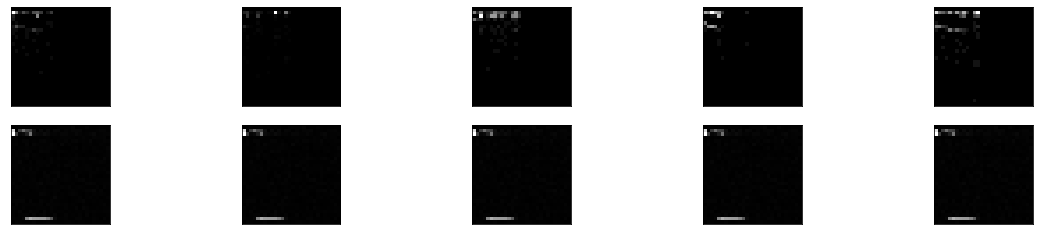

In [36]:
with torch.no_grad():
    y = train_loader.dataset.train_labels
    number = len(np.unique(y))
    print(number)
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(all_reg_x[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(all_reconstruction[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [21]:
all_enc_out.shape

torch.Size([6672, 128])

In [20]:
np.save("npy/autoencoder_flow_mnist_X.npy", all_reg_x.cpu().detach().numpy())
np.save("npy/autoencoder_flow_mnist_enc_X.npy", all_enc_out.cpu().detach().numpy())
np.save("npy/autoencoder_flow_mnist_y.npy", all_y.cpu().detach().numpy())